In [1]:
import os
import tempfile
import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import scvi
import seaborn as sns
import torch
import pertpy as pt

import muon as mu

from _quasiSCVI import QuasiSCVI
from _quasivae import QuasiVAE


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.3


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [3]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

Here we use the pancreas dataset described in the [scIB](https://github.com/theislab/scib) manuscript, that is also widely used to benchmark integration methods.

In [4]:
mdata = pt.dt.papalexi_2021()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name beca

In [5]:
mdata["rna"].layers['counts'] = mdata["rna"].X

In [6]:
mdata["rna"]


AnnData object with n_obs × n_vars = 20729 × 18649
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
    var: 'name'
    layers: 'counts'

In [7]:
mdata["rna"]

sc.pp.normalize_total(mdata["rna"])
sc.pp.log1p(mdata["rna"])
sc.pp.highly_variable_genes(mdata["rna"],n_top_genes=2000, batch_key="replicate",  subset=True)

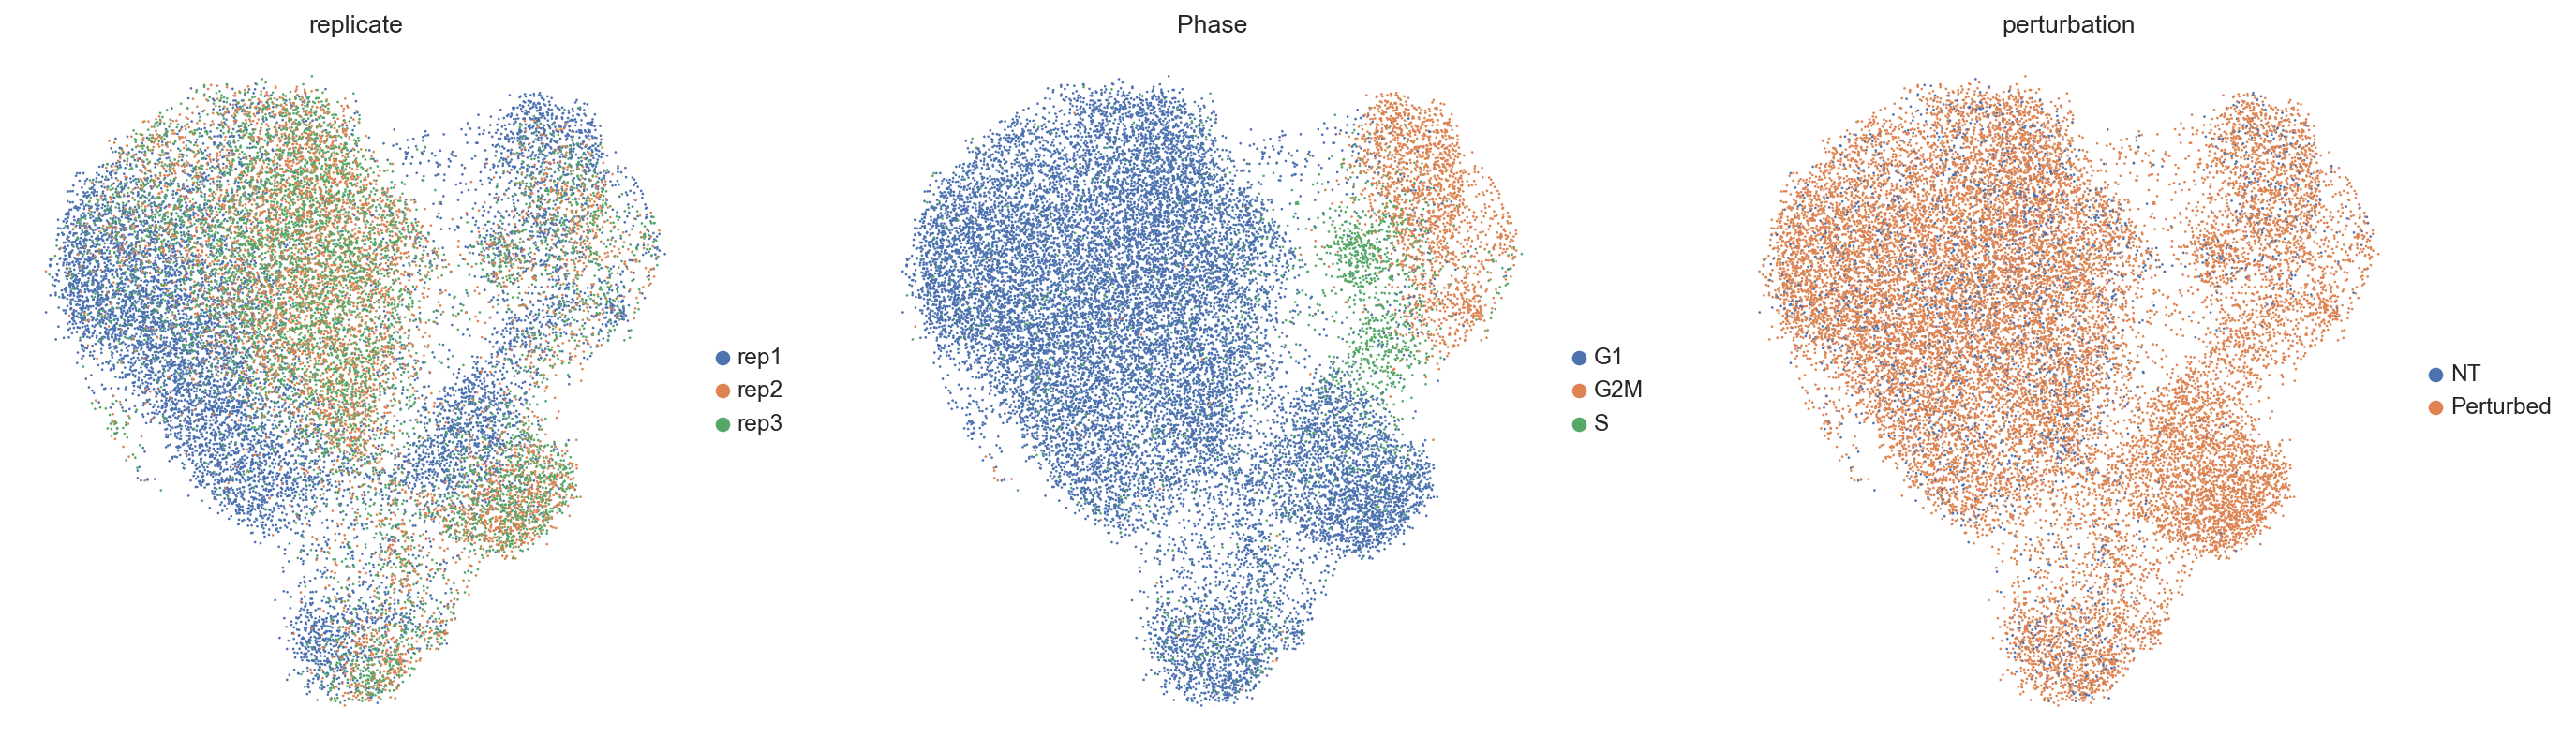

In [8]:
mdata["rna"]

sc.pp.normalize_total(mdata["rna"])
sc.pp.log1p(mdata["rna"])
sc.pp.highly_variable_genes(mdata["rna"],n_top_genes=2000, batch_key="replicate",  subset=True)
sc.pp.pca(mdata["rna"])
sc.pp.neighbors(mdata["rna"], metric="cosine")
sc.tl.umap(mdata["rna"])
sc.pl.umap(mdata["rna"], color=["replicate", "Phase", "perturbation"])

In [9]:
mdata_ref = mdata["rna"].copy()

In [10]:
#### Quasi Likelihood Model

In [11]:
QuasiSCVI.setup_anndata(mdata_ref, batch_key="replicate" , layer="counts")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


In [12]:
# Initialize the Quasi SCVI model
scvi_ref = QuasiSCVI(
    mdata_ref,
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)

# Train the model
scvi_ref.train(max_epochs=100, plan_kwargs={"lr": 1e-4})

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 100/100: 100%|███████████████████████████████████████████| 100/100 [05:26<00:00,  3.01s/it, v_num=1, train_loss_step=339, train_loss_epoch=340]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|███████████████████████████████████████████| 100/100 [05:26<00:00,  3.26s/it, v_num=1, train_loss_step=339, train_loss_epoch=340]


In [13]:
scvi_ref.history["elbo_train"]
train_loss = scvi_ref.history["elbo_train"]
kl_divergence = scvi_ref.history["kl_local_train"]

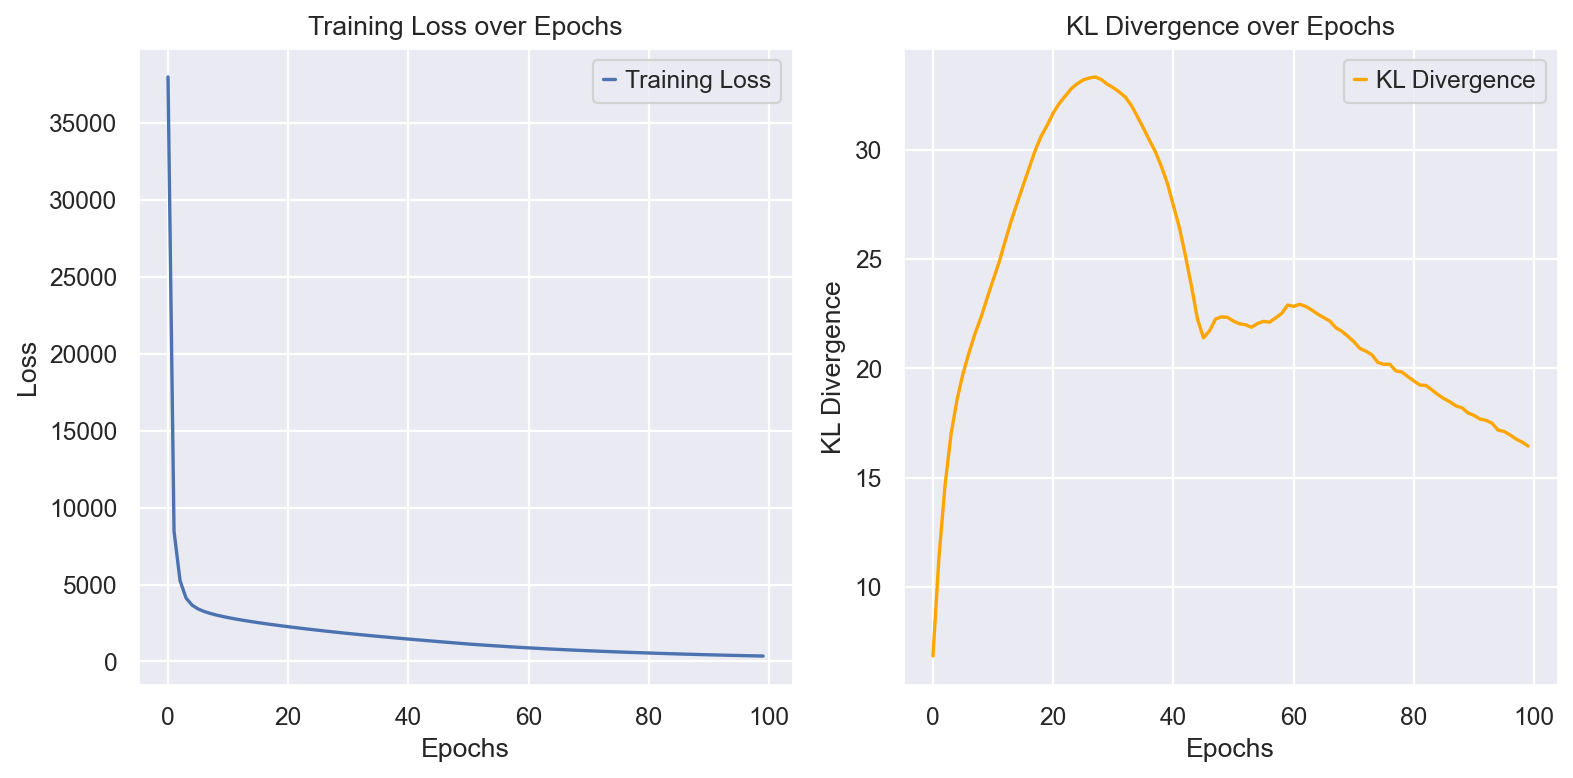

In [14]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Plot KL divergence
plt.subplot(1, 2, 2)
plt.plot(kl_divergence, label='KL Divergence', color='orange')
plt.xlabel('Epochs')
plt.ylabel('KL Divergence')
plt.title('KL Divergence over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Now we obtain the latent representation, and use Scanpy to visualize with UMAP.

In [15]:
SCVI_LATENT_KEY = "X_scVI"

mdata_ref.obsm[SCVI_LATENT_KEY] = scvi_ref.get_latent_representation()
sc.pp.neighbors(mdata_ref, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(mdata_ref)
sc.tl.umap(mdata_ref)

/var/folders/3k/yfw07yqn6nbdwjkxhf022b2m0000gn/T/ipykernel_14322/1824613379.py:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(mdata_ref)


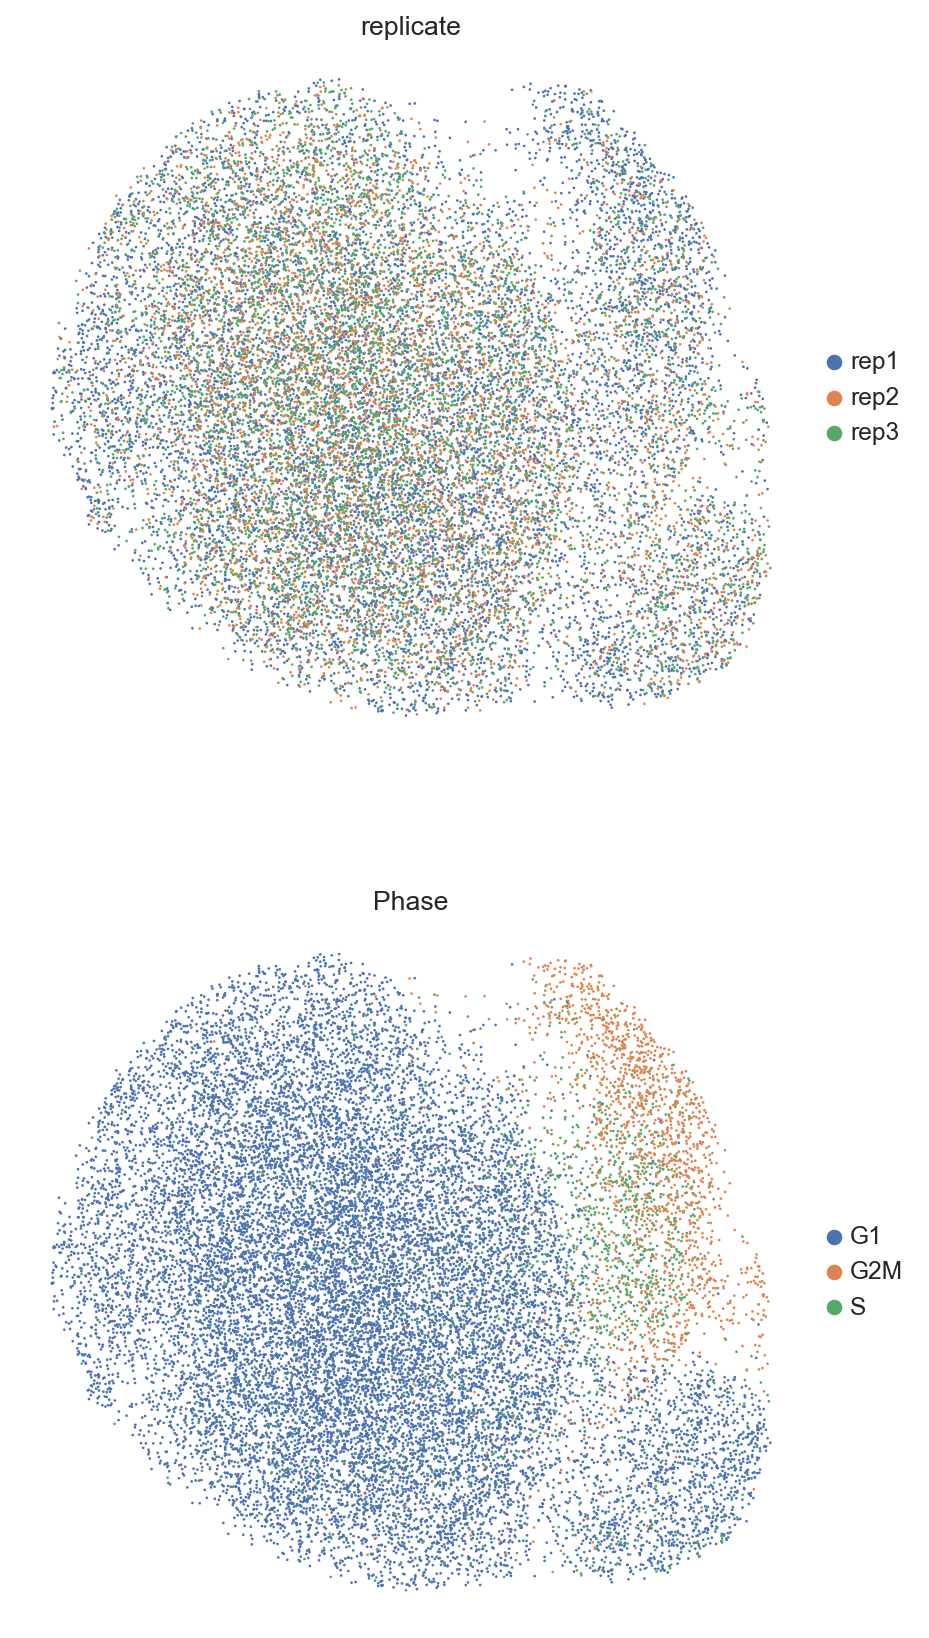

In [16]:
sc.pl.umap(
    mdata_ref,
    color=["replicate","Phase"],
    frameon=False,
    ncols=1,
)

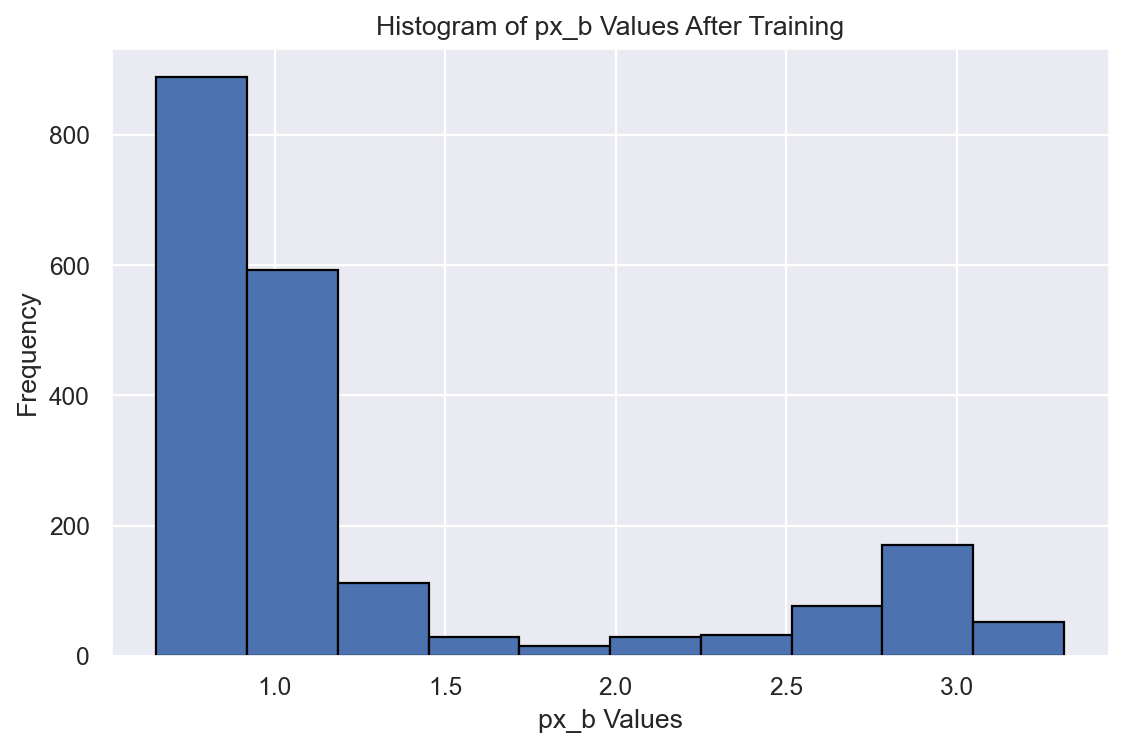

In [17]:
px_b_values = scvi_ref.module.px_b.cpu().detach().numpy()

# Plot the histogram
plt.figure(figsize=(8, 5))
plt.hist(px_b_values, bins=10, edgecolor='black')
plt.xlabel('px_b Values')
plt.ylabel('Frequency')
plt.title('Histogram of px_b Values After Training')
plt.grid(True)
plt.show()

In [100]:
print("Shape of px_b:", px_b_values.shape)


Shape of px_b: (2000,)


In [79]:
mdata_ref

AnnData object with n_obs × n_vars = 20729 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'replicate_colors', 'Phase_colors', 'perturbation_colors', '_scvi_uuid', '_scvi_manager_uuid', 'leiden'
    obsm: 'X_pca', 'X_umap', 'X_scVI'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [80]:
mdata_ref = scvi_ref._validate_anndata(mdata_ref)

In [107]:
from scvi import REGISTRY_KEYS
from scvi.module._constants import MODULE_KEYS
@torch.inference_mode()
def get_parameters(model, adata: AnnData, batch_size: int = None):
    """Get parameters from the model's decoder after training."""

    # Prepare data loader
    scdl = model._make_data_loader(adata=adata, batch_size=batch_size, shuffle=False)

    all_px_scale = []
    all_px_r = []
    all_px_rate = []
    all_px_b = []
    all_library = []

    for tensors in scdl:
        # Get inference input
        inference_input = {
            MODULE_KEYS.X_KEY: tensors[REGISTRY_KEYS.X_KEY],
            MODULE_KEYS.BATCH_INDEX_KEY: tensors[REGISTRY_KEYS.BATCH_KEY],
            MODULE_KEYS.CONT_COVS_KEY: tensors.get(REGISTRY_KEYS.CONT_COVS_KEY, None),
            MODULE_KEYS.CAT_COVS_KEY: tensors.get(REGISTRY_KEYS.CAT_COVS_KEY, None),
        }

        # Run regular inference
        inference_outputs = model.module._regular_inference(
            x=inference_input[MODULE_KEYS.X_KEY],
            batch_index=inference_input[MODULE_KEYS.BATCH_INDEX_KEY],
            cont_covs=inference_input.get(MODULE_KEYS.CONT_COVS_KEY),
            cat_covs=inference_input.get(MODULE_KEYS.CAT_COVS_KEY),
        )
        generative_input= scvi_ref.module._get_generative_input(tensors,inference_outputs)
        generative_output=scvi_ref.module.generative(
            z=generative_input[MODULE_KEYS.Z_KEY],
            library=generative_input[MODULE_KEYS.LIBRARY_KEY],
            batch_index=generative_input[MODULE_KEYS.BATCH_INDEX_KEY],
            cont_covs=generative_input.get(MODULE_KEYS.CONT_COVS_KEY),
            cat_covs=generative_input.get(MODULE_KEYS.CAT_COVS_KEY),
            size_factor=generative_input.get(MODULE_KEYS.SIZE_FACTOR_KEY),
            y=generative_input.get(MODULE_KEYS.Y_KEY))
        
         # Collect the outputs
        all_library.append(generative_input[MODULE_KEYS.LIBRARY_KEY].cpu().numpy())
        all_px_scale.append(generative_output["px_scale"].cpu().numpy())
        all_px_r.append(generative_output["px_r"].cpu().numpy())
        all_px_rate.append(generative_output["px_rate"].cpu().numpy())
        all_px_b.append(generative_output["px_b"].cpu().numpy())
        

    all_px_scale = np.concatenate(all_px_scale, axis=0)
    all_px_r = np.concatenate(all_px_r, axis=0)
    all_px_rate = np.concatenate(all_px_rate, axis=0)
    all_px_b = np.concatenate(all_px_b, axis=0)
    all_library = np.concatenate(all_library, axis=0)
    


    return all_px_scale, all_px_r, all_px_rate, all_px_b, all_library

# Use the function to get the parameters
px_scale, px_r, px_rate, px_b , library= get_parameters(scvi_ref, mdata_ref)

# You can now plot or analyze px_scale, px_r, px_rate, px_dropout as needed


In [108]:
print("Shape of all_px_scale:", px_scale.shape)
print("Shape of all_px_r:", px_r.shape)
print("Shape of all_px_rate:", px_rate.shape)
print("Shape of all_px_b:", px_b.shape)
print("Shape of all_library:",library.shape)

Shape of all_px_scale: (20729, 2000)
Shape of all_px_r: (324000,)
Shape of all_px_rate: (20729, 2000)
Shape of all_px_b: (324000,)
Shape of all_library: (20729, 1)


In [103]:
# Assuming px_scale, px_r, px_rate, px_b are obtained from the previous step
# Also, assuming 'library' is the observed library size for each cell

def plot_mean_variance(px_rate, px_r, px_b, library):
    """
    Plots the mean-variance trend with given parameters.
    
    Parameters:
    - px_rate: np.ndarray, mean values
    - px_r: np.ndarray, dispersion values
    - px_b: np.ndarray, slope values
    - library: np.ndarray, observed library sizes
    """
    # Calculate variance
    #px_r = px_r.reshape(20729, 2000)
    #px_b = px_b.reshape(20729, 2000)
    variance = px_r * np.power(px_rate, px_b)

    # Calculate mean
    mean = px_rate

    # Plot mean-variance trend
    plt.figure(figsize=(10, 6))
    plt.scatter(mean, variance, alpha=0.5, label='Data Points')

    # Plot trend line based on px_b
    slope = np.mean(px_b)  # Example: use mean of px_b as the slope
    x_vals = np.linspace(min(mean), max(mean), 100)
    trend_line = slope * x_vals
    plt.plot(x_vals, trend_line, color='red', label='Trend Line')

    plt.xlabel('Mean')
    plt.ylabel('Variance')
    plt.title('Mean-Variance Trend')
    plt.legend()
    plt.show()

# Assuming 'library' is available in your scope as a numpy array
# You can get the library size from the inference outputs if needed

# Plot the mean-variance trend
plot_mean_variance(px_rate, px_r, px_b, library)


ValueError: operands could not be broadcast together with shapes (324000,) (20729,2000) 